In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, OneHotEncoder, IDF, StringIndexer, VectorAssembler, RegexTokenizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import when, col
from pyspark.mllib.evaluation import MulticlassMetrics
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
model_path = " s3://amazon-reviews ma/models/myAmazonLogisticRegressionModel1"
model = LogisticRegressionModel.load(model_path)

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# Evaluate the model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
roc_auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
print("Test Area Under ROC: " + str(roc_auc))

Test Area Under ROC: 0.9437153976432364


In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
# Accuracy, Precision, Recall, and F1 Score
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

Accuracy:  0.8981925415884752
Precision:  0.8956481411683637
Recall:  0.8981925415884751
F1 Score:  0.8958632165565048


In [0]:
# Confusion Matrix
predictionAndLabels = predictions.select("prediction", "label").rdd
metrics = MulticlassMetrics(predictionAndLabels)
confusion_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:\n", confusion_matrix)

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
 [[ 62705.  23280.]
 [ 12797. 255583.]]


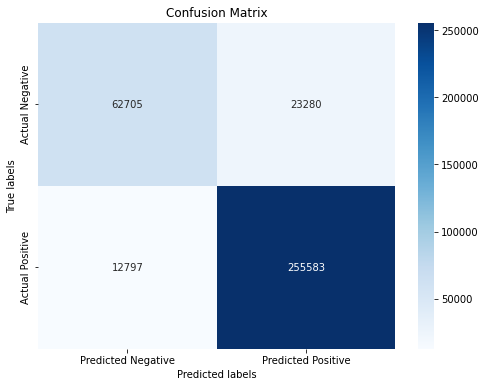

In [0]:
TN, FP, FN, TP = confusion_matrix.ravel()

import pandas as pd
conf_matrix_df = pd.DataFrame(confusion_matrix, 
                              index=["Actual Negative", "Actual Positive"], 
                              columns=["Predicted Negative", "Predicted Positive"])

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field body_features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


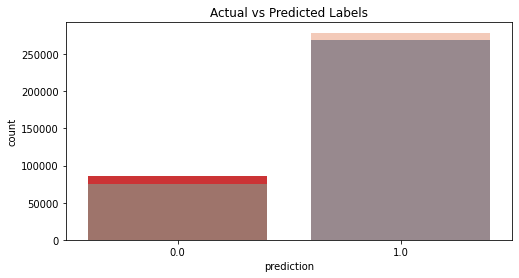

In [0]:
# Assuming `predictions` DataFrame is already available from your model
# Convert the predictions DataFrame to Pandas for visualization
predictions_pd = predictions.toPandas()

# Visualization 1: Distribution of Actual vs Predicted
plt.figure(figsize=(8, 4))
sns.countplot(x='label', data=predictions_pd, palette='Set1')
sns.countplot(x='prediction', data=predictions_pd, palette='Set2', alpha=0.5)
plt.title('Actual vs Predicted Labels')
plt.show()

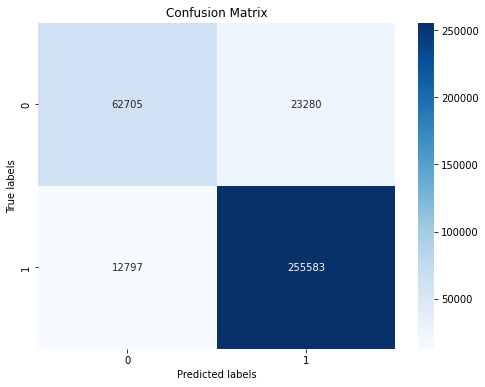

In [0]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Now you can proceed with your visualization
conf_matrix = confusion_matrix(predictions_pd['label'], predictions_pd['prediction'])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field rawPrediction. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


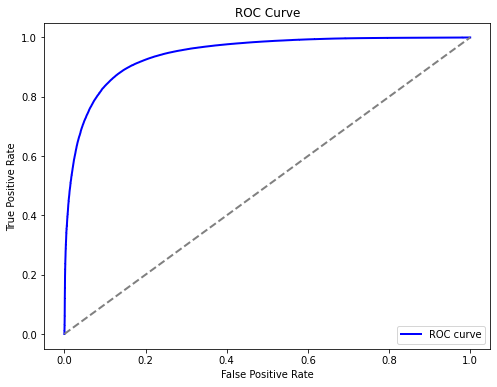

In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import pandas as pd

# Convert predictions to Pandas DataFrame
predictions_pd = predictions.select('label', 'rawPrediction').toPandas()

# Extract probability of the positive class (assuming binary classification)
predictions_pd['probability'] = predictions_pd['rawPrediction'].apply(lambda x: list(x)[1])

# Compute ROC metrics
fpr, tpr, thresholds = roc_curve(predictions_pd['label'], predictions_pd['probability'])

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field rawPrediction. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


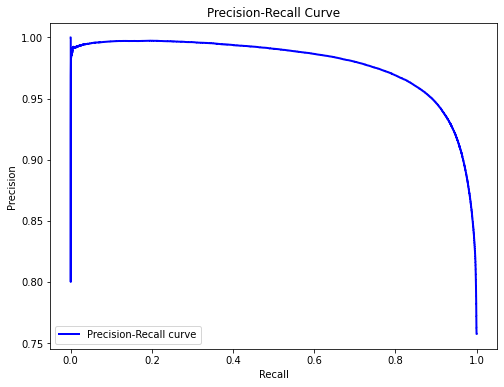

In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import pandas as pd

# Convert predictions to Pandas DataFrame
predictions_pd = predictions.select('label', 'rawPrediction').toPandas()

# Extract probability of the positive class (assuming binary classification)
predictions_pd['probability'] = predictions_pd['rawPrediction'].apply(lambda x: list(x)[1])

# Compute Precision-Recall metrics
precision, recall, thresholds = precision_recall_curve(predictions_pd['label'], predictions_pd['probability'])

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field body_features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


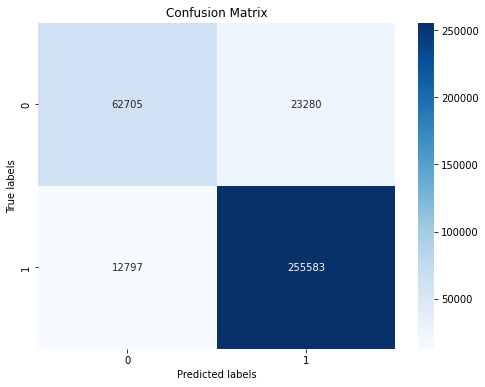

In [0]:
from pyspark.sql import SparkSession
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Initialize Spark session (if not already done)
spark = SparkSession.builder.appName("Visualization").getOrCreate()

# Assuming 'predictions' is a Spark DataFrame resulting from your model's predictions
# Convert the predictions Spark DataFrame to a Pandas DataFrame for visualization
predictions_pd = predictions.toPandas()

# Visualization: Confusion Matrix Heatmap
conf_matrix = confusion_matrix(predictions_pd['label'], predictions_pd['prediction'])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.sql.types import DoubleType
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, HashingTF, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder.appName("SimplifiedClassificationModeling").getOrCreate()

# Read the cleaned data
sdf = spark.read.parquet("s3://amazon-reviews-ma/raw/cleaned_amazon_reviews_us_Apparel_v1_00.parquet")

# Feature Engineering
sdf = sdf.withColumn("label", when(col("star_rating") > 3, 1).otherwise(0).cast(DoubleType()))
sampled_sdf = sdf.sample(withReplacement=False, fraction=0.3, seed=42)

# Text processing for 'clean_review_body' and 'clean_review_headline'
bodyTokenizer = RegexTokenizer(inputCol="clean_review_body", outputCol="tokenized_body", pattern="\\W")
bodyRemover = StopWordsRemover(inputCol="tokenized_body", outputCol="filtered_body")
bodyHashingTF = HashingTF(inputCol="filtered_body", outputCol="body_features", numFeatures=1000)
headlineTokenizer = RegexTokenizer(inputCol="clean_review_headline", outputCol="tokenized_headline", pattern="\\W")
headlineRemover = StopWordsRemover(inputCol="tokenized_headline", outputCol="filtered_headline")
headlineHashingTF = HashingTF(inputCol="filtered_headline", outputCol="headline_features", numFeatures=1000)

# Assemble features
assembler = VectorAssembler(inputCols=["body_features", "headline_features"], outputCol="final_features")

# Logistic Regression Model
classifier = LogisticRegression(featuresCol="final_features", labelCol="label")

# Create a Pipeline
pipeline = Pipeline(stages=[bodyTokenizer, bodyRemover, bodyHashingTF, headlineTokenizer, headlineRemover, headlineHashingTF, assembler, classifier])

# Split data
train_data, test_data = sampled_sdf.randomSplit([0.8, 0.2], seed=42)

# Fit the model
model = pipeline.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

In [0]:
# Grid Search for Model Optimization
paramGrid = ParamGridBuilder() \
    .addGrid(classifier.regParam, [0.1]) \
    .addGrid(classifier.elasticNetParam, [0.0, 1.0]) \
    .addGrid(bodyHashingTF.numFeatures, [1000]) \
    .addGrid(headlineHashingTF.numFeatures, [1000]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=2) ## Reduced from 3 to 2

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train_data)

# Use the best model to make predictions and evaluate
cvPredictions = cvModel.transform(test_data)

# Evaluate the best model
evaluator = BinaryClassificationEvaluator()
roc_auc = evaluator.evaluate(cvPredictions, {evaluator.metricName: "areaUnderROC"})
print("Best Model Test Area Under ROC: " + str(roc_auc))


Best Model Test Area Under ROC: 0.9401757446268977


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
File <command-1357472194113612>:34
     32 bestModelPredictionAndLabels = cvPredictions.select("prediction", "label").rdd
     33 bestMetrics = BinaryClassificationMetrics(bestModelPredictionAndLabels)
---> 34 fpr_best, tpr_best = zip(*bestMetrics.roc().collect())
     36 plt.figure()
     37 plt.plot(fpr_best, tpr_best, label='ROC curve (Best Model)')

AttributeError: 'BinaryClassificationMetrics' object has no attribute 'roc'

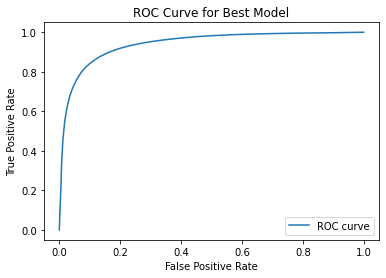

In [0]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Assuming 'cvPredictions' contains a column 'probability' with the probability of the positive class
# You might need to adjust this part based on the output of your model
probabilities = cvPredictions.select("probability").rdd.map(lambda row: row[0][1]).collect()
labels = cvPredictions.select("label").rdd.map(lambda row: row[0]).collect()

fpr, tpr, thresholds = roc_curve(labels, probabilities)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best Model')
plt.legend(loc="lower right")
plt.show()
